<img src='https://github.com/LinkedEarth/Logos/raw/master/PYLEOCLIM_logo_HORZ-01.png' width="800">

# Working with GeoSeries

## Authors
[Deborah Khider](https://orcid.org/0000-0001-7501-8430), [Julien Emile-Geay](https://orcid.org/0000-0001-5920-4751).

## Preamble
The `Series` object, introduced [here](L0_a_quickstart.md), is the basic entry into the Pyleoclim universe, with very few metadata and a low bar to entry. However, geoscientific series, including paleoclimate timeseries, are often richer in information that can be leveraged for further analysis, particularly geolocation. Therefore, we created a class called `GeoSeries`, which is a child of the `Series` object. As a child, `GeoSeries` inherits all the methods of its parent class as well as new methods that take advantage of the richer information. 

The `Series` properties, which also apply to `GeoSeries` are as followed: 

* `time`: Time values for the time series
* `value`: Paleo values for the time series
* `time_name` (optional): Name of the time vector, (e.g., 'Time', 'Age'). This is used to label the x-axis on plots
* `time_unit` (optional): The units of the time axis (e.g., 'years')
* `value_name` (optional): The name of the paleo variable (e.g., 'Temperature')
* `value_unit` (optional): The units of the paleo variable (e.g., 'deg C')
* `label` (optional): Name of the time series (e.g., 'Nino 3.4')
* `log` (dict) – Dictionary of tuples documentating the various transformations applied to the object
* `keep_log` (bool) – Whether to keep a log of applied transformations. False by default
* `importedFrom` (string) – source of the dataset. If it came from a LiPD file, this could be the datasetID property
* `archiveType` (string) – climate archive
* `dropna` (bool) – Whether to drop NaNs from the series to prevent downstream functions from choking on them defaults to True
* `sort_ts` (str) – Direction of sorting over the time coordinate; ‘ascending’ or ‘descending’ Defaults to ‘ascending’
* `verbose` (bool) – If True, will print warning messages if there is any
* `clean_ts` (optional): set to True to remove the NaNs and make time axis strictly prograde with duplicated timestamps reduced by averaging the values Default is None.

`GeoSeries` include the following additional properties:

* `lat` (float): latitude (**mandatory**)
* `lon` (float): longitude (**mandatory**)
* `elevation` (float): elevation
* `depth` (list): The values for the depth vector
* `depth_name` (str): Name of the depth (e.g., top depth, mid-depth)
* `depth_unit` (str): The units for the depth
* `sensorType` (str): The type of sensor (e.g., foraminifera, buoys)
* `observationType` (str): The type of observations made (e.g., Mg/Ca, tree-ring width, )

As with the case with `Series`, the data can be ingested in different ways.  

### Goals:
* Create Pyleoclim Series objects from datasets stored as LiPD, NOAA txt files, and from PANGAEA. This tutorials also go more in depth with using the NOAA API compared to the one presented in [working with `Series`](L0_loading_to_series.md). 

**Reading Time:** 5 minutes

### Keywords

CSV; NetCDF; LiPD, Series; EnsembleSeries; MultipleSeries

### Pre-requisites

None. This tutorial assumes basic knowledge of Python. If you are not familiar with this coding language, check out this tutorial: http://linked.earth/ec_workshops_py/.

### Relevant Packages

Pandas; Xarray; Pandas; Xarray; pylipd; pangaeapy

## Data Description

* McCabe-Glynn, S., Johnson, K., Strong, C. et al. Variable
North Pacific influence on drought in southwestern North America since AD 854. Nature Geosci 6, 617–621 (2013).
[doi:10.1038/ngeo1862](https://doi.org/10.1038/ngeo1862)

* Euro2k database: PAGES2k Consortium., Emile-Geay, J., McKay, N. et al. A global multiproxy database for temperature
 reconstructions of the Common Era. Sci Data 4, 170088 (2017). [doi:10.1038/sdata.2017.88](https://doi.org/10.1038/sdata.2017.88)

## Demonstration
First we import our favorite packages:

In [1]:
import pyleoclim as pyleo
from pylipd.lipd import LiPD
import xarray as xr
import pandas as pd
from pangaeapy.pandataset import PanDataSet
import numpy as np

### LiPD

For this demonstration, we will be reusing the same datasets and workflows as described [here](http://linked.earth/PyleoTutorials/notebooks/L0_loading_to_series.html). But we will be instantiating `GeoSeries` instead of `Series` and looking at the extra functionalities that come with this new class. 

#### Loading a single file

In [2]:
data_path = '../data/Crystal.McCabe-Glynn.2013.lpd'
D = LiPD()
D.load(data_path)

Loading 1 LiPD files


100%|██████████| 1/1 [00:00<00:00,  2.16it/s]

Loaded..


In [3]:
d, df = D.get_timeseries(D.get_all_dataset_names(), to_dataframe=True)
df_filter=df[df['paleoData_variableName']=='d18o']

Extracting timeseries from dataset: Crystal.McCabe-Glynn.2013 ...


Let's have a look at the available metadata (column headers in the DataFrame):

In [4]:
df.columns

Index(['mode', 'time_id', 'geo_meanLon', 'geo_meanLat', 'geo_meanElev',
       'geo_type', 'investigator', 'lipdVersion', 'hasUrl', 'funding1_agency',
       'funding1_grant', 'funding2_grant', 'funding2_agency', 'funding3_grant',
       'funding3_agency', 'pub1_author', 'pub1_journal', 'pub1_title',
       'pub1_pages', 'pub1_doi', 'pub1_abstract', 'pub1_volume', 'pub1_year',
       'pub1_pubDataUrl', 'pub1_DOI', 'dataSetName', 'createdBy',
       'archiveType', 'tableType', 'paleoData_tableName', 'paleoData_filename',
       'paleoData_missingValue', 'age', 'ageUnits', 'depth', 'depthUnits',
       'paleoData_TSid', 'paleoData_hasMeanValue', 'paleoData_number',
       'paleoData_hasMedianValue', 'paleoData_hasMinValue',
       'paleoData_takenAtDepth', 'paleoData_variableName', 'paleoData_units',
       'paleoData_inferredVariableType', 'paleoData_hasMaxValue',
       'paleoData_variableType', 'paleoData_values',
       'paleoData_proxyObservationType', 'paleoData_hasResolution_hasMa

From this, we can create a GeoSeries as follows:

In [12]:
metadata_dict={'time': df_filter['age'].iloc[0],
              'value': df_filter['paleoData_values'].iloc[0],
              'time_name': 'Time', 'label': df_filter['dataSetName'].iloc[0],
              'time_unit': 'year CE',
              'value_name': df_filter['paleoData_variableName'].iloc[0],
              'value_unit': df_filter['paleoData_units'].iloc[0],
              'lat':df_filter['geo_meanLat'].iloc[0],
              'lon':df_filter['geo_meanLon'].iloc[0], 
              'elevation': df_filter['geo_meanElev'].iloc[0],    
               'archiveType': df_filter['archiveType'].iloc[0],
               'observationType': df_filter['paleoData_proxyObservationType'].iloc[0],
              }

ts = pyleo.GeoSeries(**metadata_dict)

Time axis values sorted in ascending order


Let's give this series better labels for better plots:

In [16]:
ts.value_name = '$\delta^{18}$O'
ts.value_unit = "‰ VPDB"

(<Figure size 1000x400 with 1 Axes>,
 <Axes: xlabel='Time [year CE]', ylabel='$\\delta^{18}$O [‰ VPDB]'>)

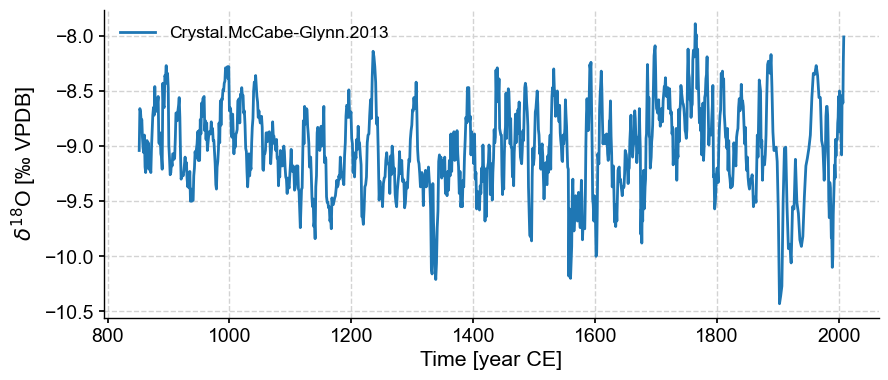

In [17]:
ts.plot()

Additional methods enabled by `GeoSeries` currently involve mapping. For instance, let's map the location of this record:

(<Figure size 1800x700 with 2 Axes>,
 {'map': <GeoAxes: xlabel='lon', ylabel='lat'>, 'leg': <Axes: >})

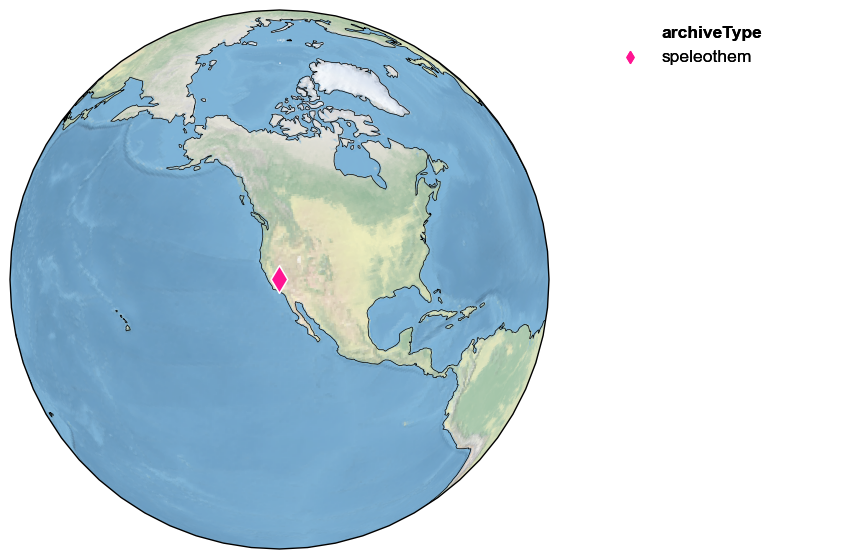

In [18]:
ts.map()

Let's draw a thicker black edge around the symbol:

(<Figure size 1800x700 with 2 Axes>,
 {'map': <GeoAxes: xlabel='lon', ylabel='lat'>, 'leg': <Axes: >})

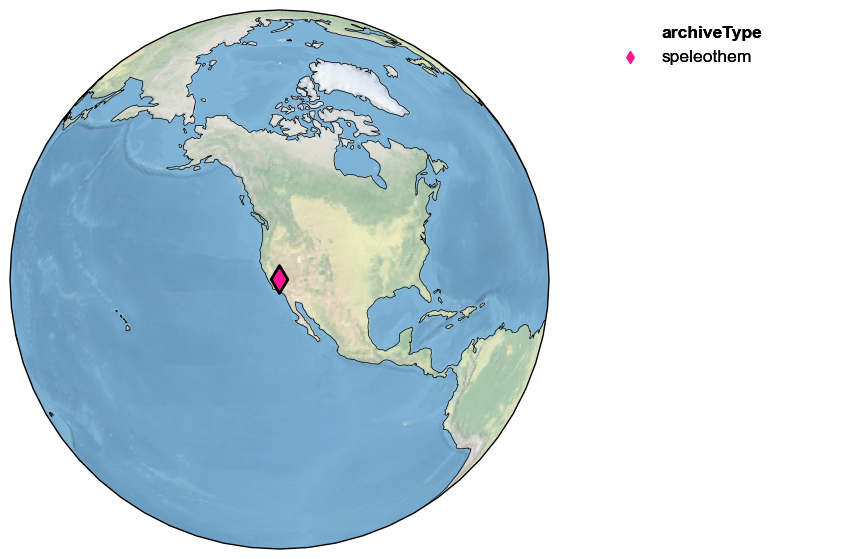

In [25]:
ts.map(scatter_kwargs ={'edgecolor':'black', 'linewidth':2})

You can also create a dashboard summarizing the location of the record, plots the timeseries and runs spectral analysis to generate a periodogram: 

Performing spectral analysis on individual series: 100%|██████████| 200/200 [00:28<00:00,  7.01it/s]


(<Figure size 1100x800 with 4 Axes>,
 {'ts': <Axes: xlabel='Time [year CE]', ylabel='$\\delta^{18}$O [‰ VPDB]'>,
  'dts': <Axes: xlabel='Counts'>,
  'map': {'map': <GeoAxes: xlabel='lon', ylabel='lat'>},
  'spec': <Axes: xlabel='Period [yrs]', ylabel='PSD'>})

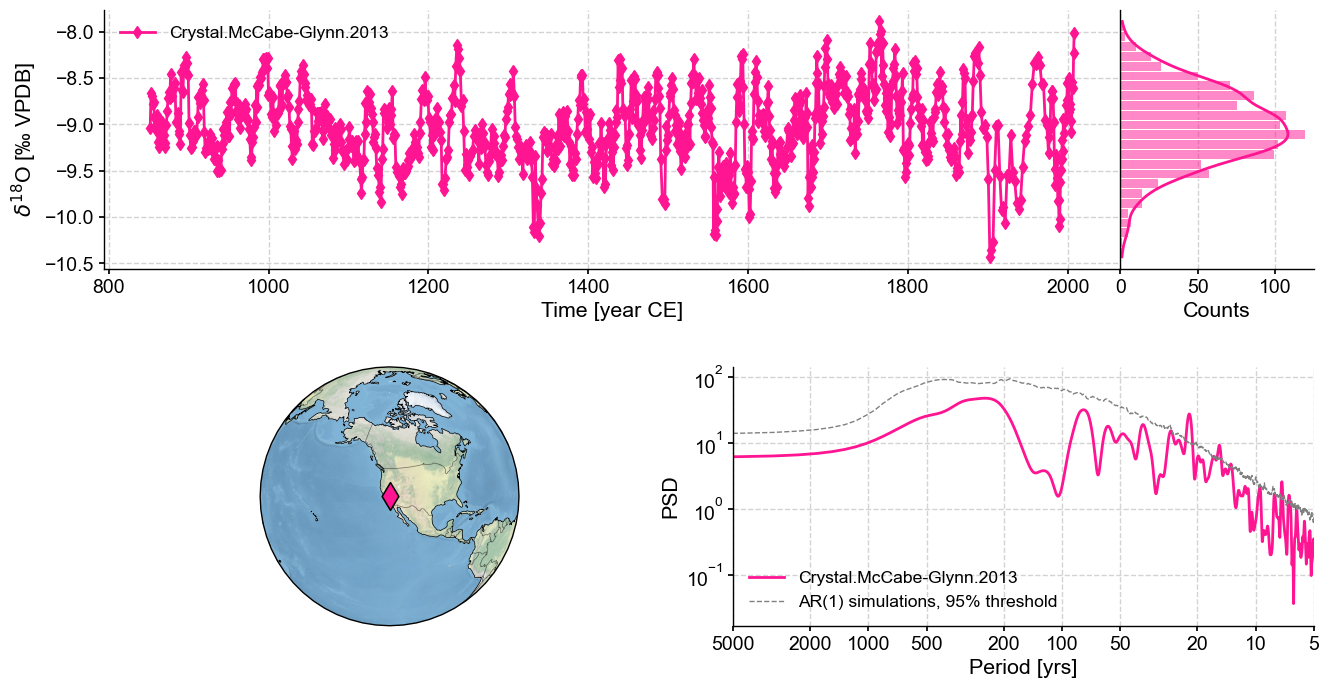

In [26]:
ts.dashboard()

## MultipleGeoSeries

Just like its parent class `Series`, `GeoSeries` exists in multiple form as well: `MultipleGeoSeries` has all the methods of `MultipleGeoSeries` plus some that are enabled by the additional metadata, particularly geolocation. 
One can easily generate such object by joining `GeoSeries` one by one, using the "&" method, as done in [this example](https://pyleoclim-util.readthedocs.io/en/latest/core/api.html#pyleoclim.core.multipleseries.MultipleSeries.increments). 

Here we show how to generate such an object by querying the [LiPDGraph](https://linkedearth.graphdb.mint.isi.edu) to obtain datasets from the PAGES2k database that are within the 20-60$^{\circ}$ N band. In this we make use of the [pylipd](https://pylipd.readthedocs.io/en/latest/) package, which will return everything in a [pandas DataFrame](https://pandas.pydata.org/docs/reference/frame.html). 

In [34]:
import json
import requests
import io


url = 'https://linkedearth.graphdb.mint.isi.edu/repositories/LiPDVerse3'

query = """

PREFIX le: <http://linked.earth/ontology#>
PREFIX wgs: <http://www.w3.org/2003/01/geo/wgs84_pos#>

select ?val ?timeval ?varunits ?timeunits ?varname ?timevarname ?dsname ?lat ?lon ?alt ?archive ?proxy where { 
    
    ?ds le:name ?dsname .
        OPTIONAL {?ds le:proxyArchiveType ?archive .} 
    ?ds le:includesPaleoData ?data .
    
    ?ds le:collectedFrom ?loc . 
    ?loc wgs:lat ?lat .
        FILTER(?lat<60 && ?lat>20) 
    ?loc wgs:long ?lon .
    ?loc wgs:alt ?alt .
    
    ?data le:foundInMeasurementTable ?table .
    ?table le:includesVariable ?var .
    ?var le:name ?varname .
        FILTER regex(?varname, "temperature.*") .
    ?var le:hasValues ?val .
    ?var le:hasUnits ?varunits .
        VALUES ?varunits {"degC"} .
    ?var le:proxy ?proxy .
    ?var le:partOfCompilation ?comp .
    ?comp le:name "Pages2kTemperature" .
            
    
    ?table le:includesVariable ?timevar .
    ?timevar le:name ?timevarname .
        VALUES ?timevarname {"year"} .
    ?timevar le:hasValues ?timeval .
        OPTIONAL{?timevar le:hasUnits ?timeunits .}       
}

"""

response = requests.post(url, data = {'query': query})

data = io.StringIO(response.text)
df = pd.read_csv(data, sep=",")

# Make list from the values string
df['val']=df['val'].apply(lambda row : np.fromstring(row.strip("[]"), sep=','))
df['timeval']=df['timeval'].apply(lambda row : np.fromstring(row.strip("[]"), sep=','))

df.head()

val   
0  [27.54, 26.67, 25.87, 27.78, 27.39, 26.98, 26....  \
1  [8.62, 8.41, 8.721341659, 8.800163059, 8.87029...   
2  [20.4, 20.4, 20.7, 20.6, 20.5, 20.2, 19.3, 19....   
3  [-7.1, nan, -6.3, -4.5, -6.4, -7.8, -5.7, -5.3...   
4  [8.84, 8.6, 9.32, 9.99, 9.78, 9.88, 10.06, 9.7...   

                                             timeval varunits timeunits   
0  [1925.2, 1875.6, 1826.0, 1776.0, 1727.0, 1677....     degC        AD  \
1  [1950.0, 1820.0, 1570.0, 1510.0, 1440.0, 1360....     degC        AD   
2  [1950.0, 1937.0, 1924.0, 1911.0, 1898.0, 1886....     degC        AD   
3  [1500.0, 1501.0, 1502.0, 1503.0, 1504.0, 1505....     degC        AD   
4  [1950.0, 1942.06, 1934.12, 1926.19, 1918.25, 1...     degC        AD   

       varname timevarname                         dsname    lat    lon   
0  temperature        year     Ocn-DryTortugasA.Lund.2006  24.33 -83.26  \
1  temperature        year  Ocn-EmeraldBasin.Keigwin.2007  43.53 -62.48   
2  temperature        year     NAm-DarkLake.Gajewski.1988  45.30 -91.50   
3  temperature        year        Eur-Tallinn.Tarand.2001  59.40  24.75   
4  temperature        year  Ocn-EmeraldBasin.Keigwin.2003  45.89 -62.80   

     alt          archive        proxy  
0 -547.0  marine sediment  foram Mg/Ca  
1 -250.0  marine sediment     alkenone  
2  334.0    lake sediment       pollen  
3   10.0        documents     historic  
4 -250.0  marine sediment     alkenone

Next, we iterate over the rows, put the relevant information into the right place of a list  `GeoSeries` objects:

In [35]:
ts_list = []
for _, row in df.iterrows():
    ts_list.append(pyleo.GeoSeries(time=row['timeval'],value=row['val'],
                            time_name='Year',value_name=row['varname'],
                            time_unit=row['timeunits'], value_unit=row['varunits'],
                            lat = row['lat'], lon = row['lon'], 
                            elevation = row['alt'],   
                            archiveType = row['archive'],
                            observationType=row['proxy'],       
                            label=row['dsname']+'_'+row['proxy'], verbose = False)) 

Finally, we instantiate a `MultipleGeoSeries` out of this, and make sure to harmonize all the time units for ease of plotting:

(<Figure size 640x480 with 51 Axes>,
 {0: <Axes: ylabel='temperature [degC]'>,
  1: <Axes: ylabel='temperature [degC]'>,
  2: <Axes: ylabel='temperature [degC]'>,
  3: <Axes: ylabel='temperature [degC]'>,
  4: <Axes: ylabel='temperature [degC]'>,
  5: <Axes: ylabel='temperature [degC]'>,
  6: <Axes: ylabel='temperature [degC]'>,
  7: <Axes: ylabel='temperature [degC]'>,
  8: <Axes: ylabel='temperature [degC]'>,
  9: <Axes: ylabel='temperature [degC]'>,
  10: <Axes: ylabel='temperature [degC]'>,
  11: <Axes: ylabel='temperature [degC]'>,
  12: <Axes: ylabel='temperature [degC]'>,
  13: <Axes: ylabel='temperature [degC]'>,
  14: <Axes: ylabel='temperature [degC]'>,
  15: <Axes: ylabel='temperature [degC]'>,
  16: <Axes: ylabel='temperature [degC]'>,
  17: <Axes: ylabel='temperature [degC]'>,
  18: <Axes: ylabel='temperature [degC]'>,
  19: <Axes: ylabel='temperature [degC]'>,
  20: <Axes: ylabel='temperature [degC]'>,
  21: <Axes: ylabel='temperature [degC]'>,
  22: <Axes: ylabel='temper

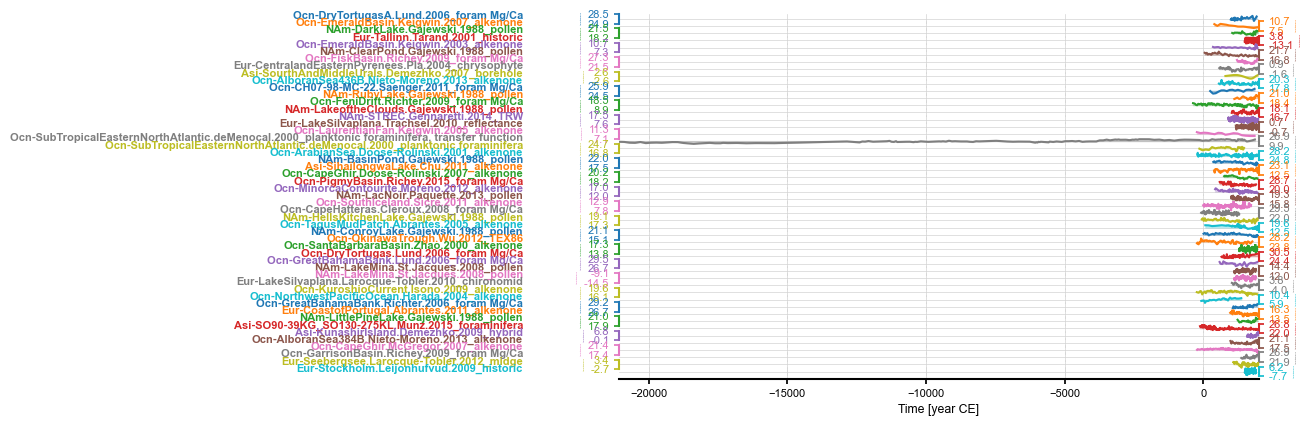

In [36]:
pages2k = pyleo.MultipleGeoSeries(ts_list,time_unit='year CE')    
pages2k.stackplot(ylabel_fontsize=0)

### Mapping collections

The first thing one might do is map those records:

(<Figure size 1800x600 with 2 Axes>,
 {'map': <GeoAxes: xlabel='lon', ylabel='lat'>, 'leg': <Axes: >})

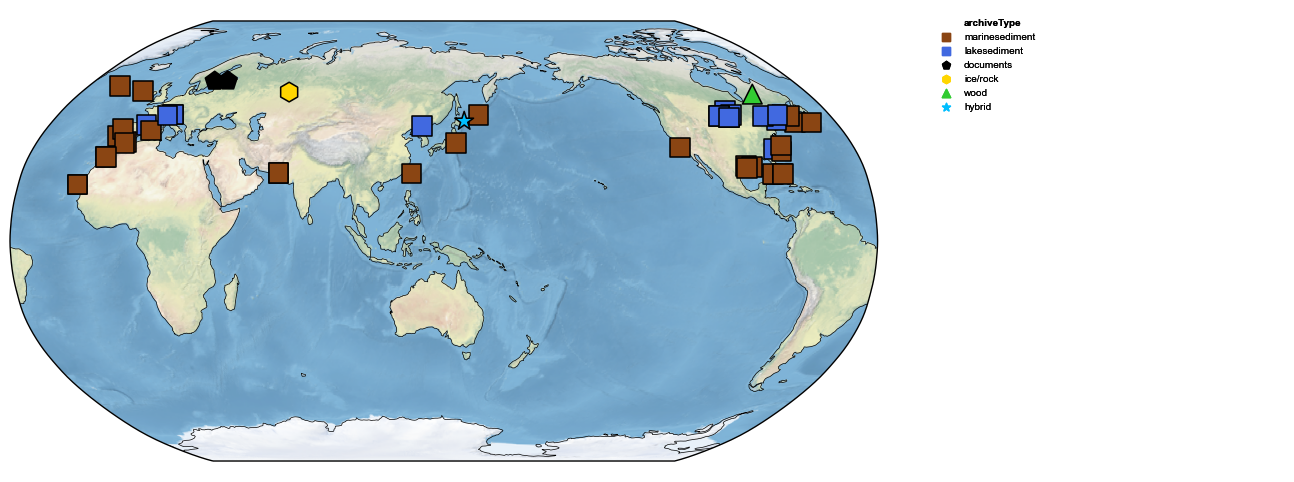

In [37]:
pages2k.map()

Let's say we wanted to focus on those parts of PAGES2k in North America; you could focus the map in this way, and use a more appropriate projection:

(<Figure size 1800x700 with 2 Axes>,
 {'map': <GeoAxes: xlabel='lon', ylabel='lat'>, 'leg': <Axes: >})

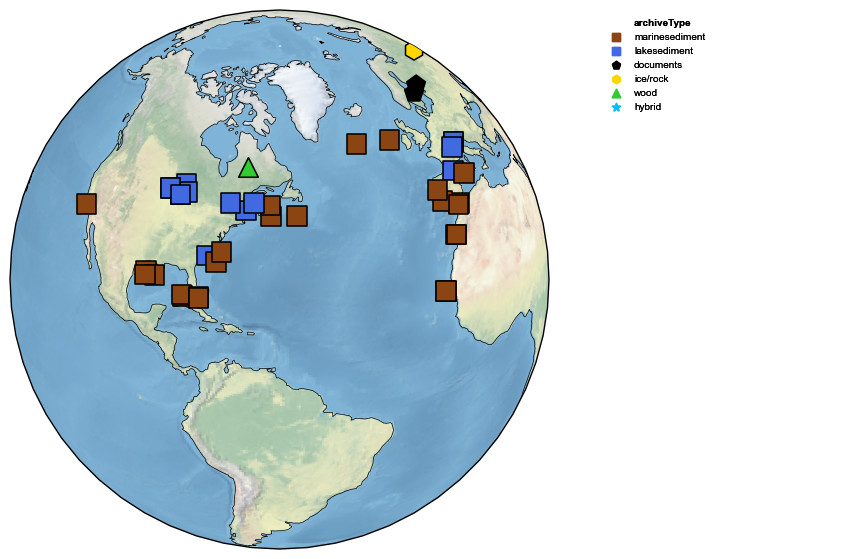

In [46]:
NAm_coord = {'central_latitude':30, 'central_longitude':-60}
pages2k.map(projection='Orthographic',proj_default=NAm_coord) 

By default, the shape and colors of symbols denote proxy archives; however, one can use either graphical device to convey other information. For instance, if elevation is available, it may be displayed by size, like so: 

(<Figure size 1800x700 with 2 Axes>,
 {'map': <GeoAxes: xlabel='lon', ylabel='lat'>, 'leg': <Axes: >})

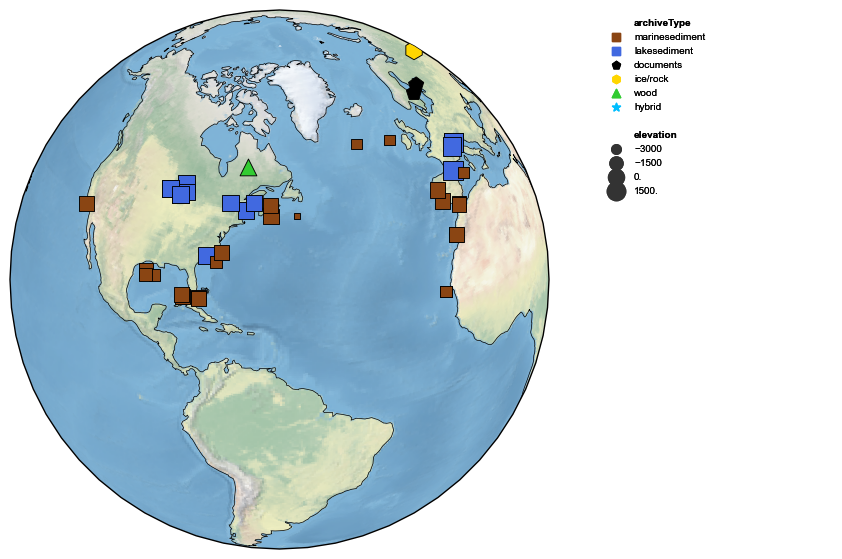

In [47]:
pages2k.map(projection='Orthographic', size='elevation', proj_default=NAm_coord) 

Same with observationType:

(<Figure size 1800x700 with 2 Axes>,
 {'map': <GeoAxes: xlabel='lon', ylabel='lat'>, 'leg': <Axes: >})

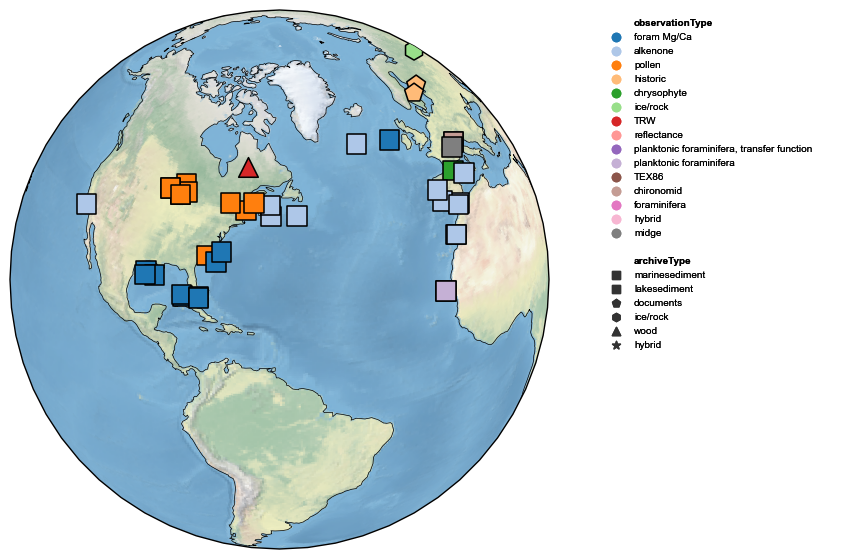

In [48]:
pages2k.map(projection='Orthographic', hue = 'observationType', proj_default=NAm_coord) 

All three sources of information may be combined, but the figure height will need to be enlarged manually to fit the legend:            

(<Figure size 1800x800 with 2 Axes>,
 {'map': <GeoAxes: xlabel='lon', ylabel='lat'>, 'leg': <Axes: >})

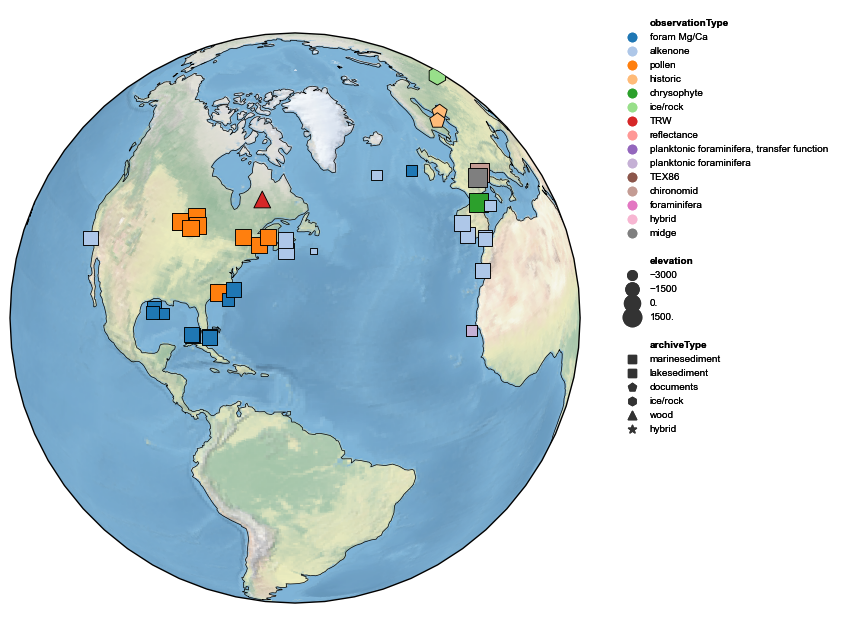

In [49]:
pages2k.map(projection='Orthographic',hue='observationType',
                       size='elevation', proj_default=NAm_coord, figsize=[18, 8]) 

### Mapping Neighbors
Let's return to our Crystal Cave example. How many PAGES2k records identified above lie within a certain radius of this cave? That is easy to map:

(<Figure size 1800x700 with 2 Axes>,
 {'map': <GeoAxes: xlabel='lon', ylabel='lat'>, 'leg': <Axes: >})

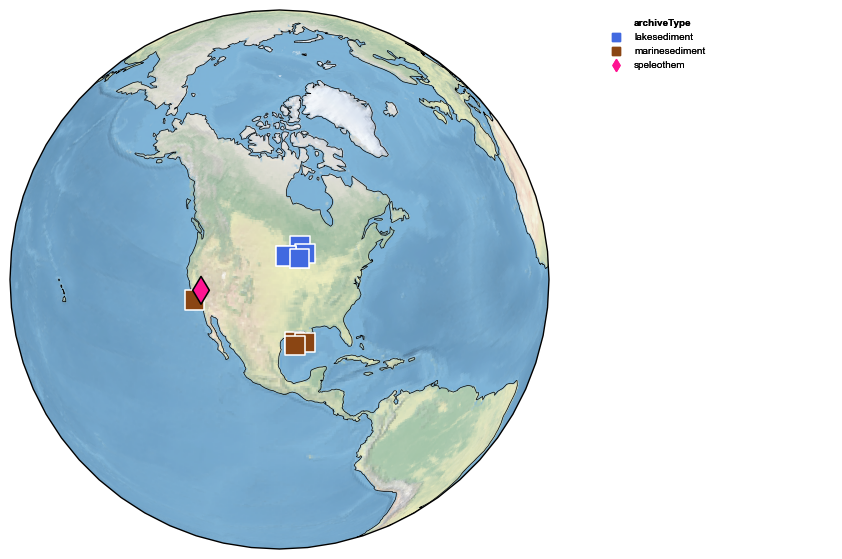

In [50]:
ts.map_neighbors(pages2k)

Note how the target record (here, Crystal Cave) is outlined in black, while all the other ones are outlined in white. It is easy to widen the search radius to inclde more records:

(<Figure size 1800x700 with 2 Axes>,
 {'map': <GeoAxes: xlabel='lon', ylabel='lat'>, 'leg': <Axes: >})

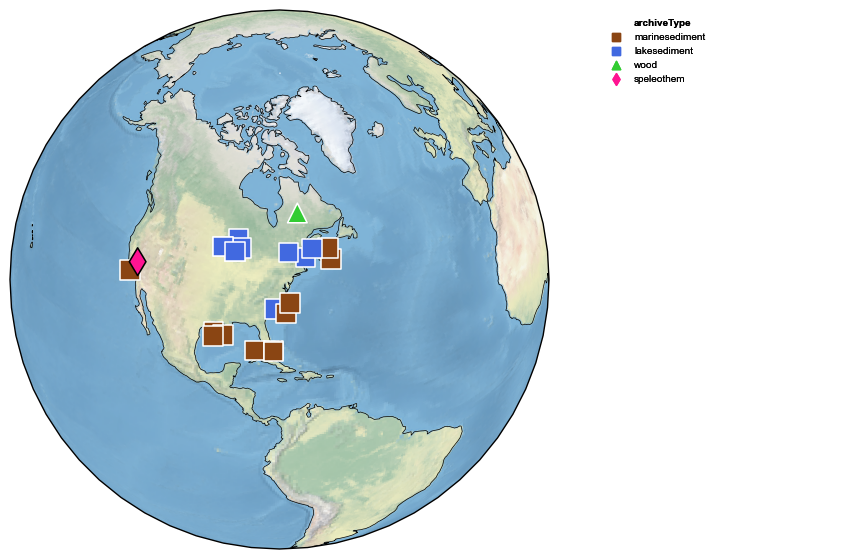

In [51]:
ts.map_neighbors(pages2k, radius=5000)

For examples of actual data analysis using `MultipleGeoSeries`, see the tutorial on [Principal Component Analysis](L2_principal_component_analysis.md). 

## Loading NOAA Files (to be done)

NOAA has made availabe an API to query their database: all of their metadata is standardized, however, only the most recent studies use their templates for the data; which might make it difficult to automatically create `GeoSeries`. However, it can programatically search their dataholdings and encode the manual cleaning steps for the data for reproducibility. 
